In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder

## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_4.csv')

In [ ]:
dataset.shape

(1210, 2)

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

1160    rest spiritual furniture modest scattered tend...
557     meantime widow cranfield went bustling house f...
1181    offered hand took grasp became would seen fine...
1084    long reached spot rather tall house uninhabite...
253     seeing grown one fairest maidens many valorous...
802     call multiplied cares housekeeping without sub...
1119    use try follow farther to-night thought youth ...
34      period landing clive young writer india close ...
320     rudge could leave wife daughters without retur...
790     could come nothing kindly terms went engaged d...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


# TextVectorization

## Model 1

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 256)         15360000  
                                                                 
 conv1d (Conv1D)             (None, 5997, 512)         524800    
                                                                 
 max_pooling1d (MaxPooling1  (None, 2998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 512)               0     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 32, callbacks=[model_checkpoint_callback])

Epoch 1/10
28/28 [==============================] - 15s 264ms/step - loss: 2.8678 - accuracy: 0.0930 - val_loss: 2.7364 - val_accuracy: 0.0928
Epoch 2/10
28/28 [==============================] - 5s 194ms/step - loss: 2.5577 - accuracy: 0.1676 - val_loss: 2.5627 - val_accuracy: 0.1443
Epoch 3/10
28/28 [==============================] - 5s 195ms/step - loss: 2.3041 - accuracy: 0.2468 - val_loss: 2.2980 - val_accuracy: 0.2577
Epoch 4/10
28/28 [==============================] - 5s 192ms/step - loss: 1.8555 - accuracy: 0.4328 - val_loss: 1.8220 - val_accuracy: 0.4742
Epoch 5/10
28/28 [==============================] - 5s 193ms/step - loss: 1.2500 - accuracy: 0.6234 - val_loss: 1.3024 - val_accuracy: 0.6082
Epoch 6/10
28/28 [==============================] - 5s 192ms/step - loss: 0.7617 - accuracy: 0.7819 - val_loss: 0.9572 - val_accuracy: 0.7423
Epoch 7/10
28/28 [==============================] - 5s 192ms/step - loss: 0.5201 - accuracy: 0.8427 - val_loss: 0.7568 - val_accuracy: 0.8041
Epoch

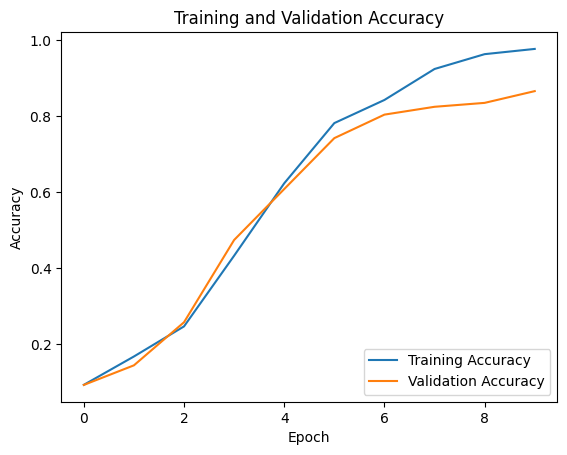

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 63ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9256198347107438
F1 Score: 0.9264196995471462
Precision: 0.9361528278883652
Recall: 0.9256198347107438


## Model 2

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(256, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 6000)              0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 conv1d_1 (Conv1D)           (None, 5997, 512)         524800    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2998, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 2995, 256)         5245

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
109/109 [==============================] - 18s 138ms/step - loss: 2.7632 - accuracy: 0.0918 - val_loss: 2.6369 - val_accuracy: 0.0928
Epoch 2/10
109/109 [==============================] - 14s 127ms/step - loss: 2.3772 - accuracy: 0.1665 - val_loss: 2.1289 - val_accuracy: 0.2577
Epoch 3/10
109/109 [==============================] - 13s 123ms/step - loss: 2.0139 - accuracy: 0.2491 - val_loss: 1.7780 - val_accuracy: 0.3918
Epoch 4/10
109/109 [==============================] - 13s 117ms/step - loss: 1.6766 - accuracy: 0.3594 - val_loss: 1.5506 - val_accuracy: 0.4124
Epoch 5/10
109/109 [==============================] - 13s 120ms/step - loss: 1.3547 - accuracy: 0.4914 - val_loss: 1.4593 - val_accuracy: 0.4639
Epoch 6/10
109/109 [==============================] - 13s 117ms/step - loss: 1.0875 - accuracy: 0.5511 - val_loss: 1.3526 - val_accuracy: 0.5567
Epoch 7/10
109/109 [==============================] - 12s 109ms/step - loss: 0.9056 - accuracy: 0.6383 - val_loss: 1.3541 - val_ac

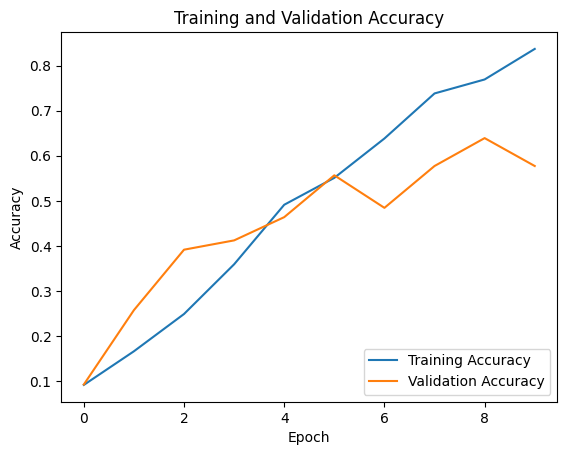

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 70ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6735537190082644
F1 Score: 0.673051122366459
Precision: 0.727923306483678
Recall: 0.6735537190082644
